In [88]:
# Beckham Carver
# Last modified: 7/29/2024
# Algorithim Selection

- US Census Bureau
- https://www.kaggle.com/datasets/joebeachcapital/campus-pride-index
- https://www.unitedstateszipcodes.org/zip-code-database/population/
- https://scikit-learn.org/stable/supervised_learning.html
- https://scikit-learn.org/stable/modules/linear_model.html
- https://scikit-learn.org/stable/modules/svm.html
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/neighbors.html
- https://scikit-learn.org/stable/modules/gaussian_process.html
- https://scikit-learn.org/stable/modules/naive_bayes.html
- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/ensemble.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
- https://saturncloud.io/blog/how-to-split-text-in-a-column-into-multiple-rows-using-pandas/
- https://stackoverflow.com/questions/38829702/summing-booleans-in-a-dataframe
- https://stackoverflow.com/questions/32059397/pandas-groupby-without-turning-grouped-by-column-into-index
- https://stackoverflow.com/questions/47040728/get-average-difference-between-all-numbers-in-a-list-python
- https://seaborn.pydata.org/generated/seaborn.pairplot.html
- https://dal.ca.libguides.com/csci/writing
- I learned LaTex just for this.
- MWolf submission, Michael Stoll submission

My goal is to investigate predictors for the 'rating score' on the Pride Ranking Index, that rates LGBTQ+ inclusivity on college campuses throughout the US. Because I have worked with this census and zipcode data previously, I decided to cross those data sets and look for any financial or population size predictors for inclusivity rating. My hypothesis is that there will be no correlation (poor predictions) between the financial and populous statistics and the pride ranking, as the presence of a college campus alone normalizes many of the socio-economic differences amongst communities, campus specific differences likely account for the differences in inclusivity.

In [89]:
import pandas as pd
import numpy as np
import sklearn
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [90]:
df = pd.read_csv('rawdata/pride-ranking-dataset/pride_index.csv')
dfz = pd.read_csv('rawdata/zip_code_database.csv')
dfi = pd.read_csv('rawdata/ACSST5Y2020.S1901-Data.csv',header=1)

In [91]:
dfz = dfz.filter(['zip', 'irs_estimated_population','primary_city', 'state'])
dfz['irs_estimated_population'] = dfz['irs_estimated_population'].astype('int64')

dfz['irs_estimated_population'] = dfz.groupby(['zip'])['irs_estimated_population'].agg('sum')
dfz.drop_duplicates(subset=['zip'], keep='first', inplace=True)

dfz.dropna(inplace=True)
dfz.rename(columns={'zip':'Zipcode'}, inplace=True)
dfz = dfz[dfz['irs_estimated_population'] != 0]

dfz['campus_location'] = dfz['primary_city'] + ', ' + dfz['state']
tmp = dfz.groupby('campus_location').agg({
    'irs_estimated_population' : lambda x: x.sum(),
    'state' : lambda x: x.iloc[0]
})

dfz = pd.merge(dfz, tmp, on=['campus_location'], how='outer', indicator=True)
dfz = dfz.loc[dfz['_merge'] == 'both'].drop('_merge', axis=1)
dfz.rename(columns={'irs_estimated_population_y' : 'irs_estimated_population', 'state_x' : 'state'}, inplace=True)
dfz = dfz[dfz['state_y'] == dfz['state']]

dfz.drop(columns=['irs_estimated_population_x', 'state_y'], inplace=True)
print(dfz.describe().T)
dfz

                            count          mean            std     min  \
Zipcode                   16291.0  52132.608680   26781.509339  1830.0   
irs_estimated_population  16291.0  67706.231048  194915.460901     9.0   

                              25%      50%      75%        max  
Zipcode                   30367.0  53290.0  74448.5    99929.0  
irs_estimated_population    950.0   6110.0  31374.5  1466452.0  


,Zipcode,primary_city,state,campus_location,irs_estimated_population
0,38601,Abbeville,MS,"Abbeville, MS",210.0
1,29620,Abbeville,SC,"Abbeville, SC",408.0
2,4406,Abbot,ME,"Abbot, ME",11310.0
3,21005,Aberdeen Proving Ground,MD,"Aberdeen Proving Ground, MD",129.0
4,21001,Aberdeen,MD,"Aberdeen, MD",5040.0
...,...,...,...,...,...
16286,33890,Zolfo Springs,FL,"Zolfo Springs, FL",359.0
16287,59546,Zortman,MT,"Zortman, MT",2770.0
16288,23898,Zuni,VA,"Zuni, VA",22180.0
16289,59547,Zurich,MT,"Zurich, MT",300.0


In [92]:
dfi = dfi.filter(['Geographic Area Name','Estimate!!Households!!Median income (dollars)','Estimate!!Households!!Total', 'Estimate!!Households!!Mean income (dollars)', 'Estimate!!Nonfamily households!!Total', 'Estimate!!Married-couple families!!Total', 'Estimate!!Families!!Total'])
dfi.rename(columns={'Estimate!!Households!!Median income (dollars)':'Median Household Income'}, inplace=True)
dfi.rename(columns={'Estimate!!Households!!Total':'Total Households'}, inplace=True)
dfi.rename(columns={'Estimate!!Households!!Mean income (dollars)':'Mean Household Income'}, inplace=True)
dfi.rename(columns={'Estimate!!Married-couple families!!Total':'Married-couple Family households'}, inplace=True)
dfi.rename(columns={'Estimate!!Nonfamily households!!Total':'Non-family households'}, inplace=True)
dfi.rename(columns={'Estimate!!Families!!Total':'Family households'}, inplace=True)
dfi.rename(columns={'Geographic Area Name':'Zipcode'}, inplace=True)

dfi.drop_duplicates(subset=['Zipcode'], keep='first')
dfi.dropna(inplace=True)

dfi['Zipcode'] = dfi['Zipcode'].apply(lambda x : x.removeprefix('ZCTA5 '))
dfi['Mean Household Income'] = dfi['Mean Household Income'].transform(lambda x: 0 if pd.isna(x) or pd.isnull(x) or x == 'N' or x == '-' else x.replace('2,500-', '1250').replace('250,000+', str(random.randrange(250000,1000000, 500)))) # crude rounding
dfi['Median Household Income'] = dfi['Median Household Income'].transform(lambda x: 0 if pd.isna(x) or pd.isnull(x) or x == 'N' or x == '-' else x.replace('2,500-', '1250').replace('250,000+', str(random.randrange(250000,1000000, 500)))) # crude rounding

dfi['Zipcode'] = dfi['Zipcode'].astype('int64')
dfi['Total Households'] = dfi['Total Households'].astype('int64')
dfi['Median Household Income'] = dfi['Median Household Income'].astype('int64')
dfi['Mean Household Income'] = dfi['Mean Household Income'].astype('int64')
dfi['Married-couple Family households'] = dfi['Married-couple Family households'].astype('int64')
dfi['Non-family households'] = dfi['Non-family households'].astype('int64')
dfi['Family households'] = dfi['Family households'].astype('int64')


print(dfi.describe().T)
dfi

                                    count          mean           std    min  \
Zipcode                           33120.0  49666.334209  27564.925769  601.0   
Median Household Income           33120.0  58903.615731  35719.802309    0.0   
Total Households                  33120.0   3730.548490   5396.181697    0.0   
Mean Household Income             33120.0  76852.308364  39159.095947    0.0   
Non-family households             33120.0   1295.245169   2082.018837    0.0   
Married-couple Family households  33120.0   1789.100936   2599.966975    0.0   
Family households                 33120.0   2435.303321   3544.793351    0.0   

                                       25%      50%       75%       max  
Zipcode                           26634.75  49739.0  72123.50   99929.0  
Median Household Income           42832.75  55873.5  72223.00  969000.0  
Total Households                    272.00   1081.0   5118.75   41335.0  
Mean Household Income             56908.50  70582.5  89517.50  

,Zipcode,Median Household Income,Total Households,Mean Household Income,Non-family households,Married-couple Family households,Family households
0,601,14398,5555,19353,1643,2354,3912
1,602,16771,12901,26150,3707,5933,9194
2,603,15786,19431,27451,6263,6942,13168
3,606,14980,1983,18534,632,591,1351
4,610,20167,8864,27865,2559,3884,6305
...,...,...,...,...,...,...,...
33115,99923,0,12,0,12,0,0
33116,99925,63125,365,77633,148,155,217
33117,99926,58000,440,69587,92,239,348
33118,99927,0,0,0,0,0,0


In [93]:
dfi = pd.merge(dfi, dfz, on=['Zipcode'], how='outer', indicator=True)
dfi = dfi.loc[dfi['_merge'] == 'both'].drop('_merge', axis=1)

df = pd.merge(df, dfi, on=['campus_location'], how='inner', indicator=True)
df = df.loc[df['_merge'] == 'both'].drop('_merge', axis=1)
df



,campus_name,campus_location,rating,students,community_type,Zipcode,Median Household Income,Total Households,Mean Household Income,Non-family households,Married-couple Family households,Family households,primary_city,state,irs_estimated_population
0,"University of Maryland, College Park","College Park, MD",5.0,37952,large urban city,20740,73315.0,9789.0,96091.0,5273.0,3412.0,4516.0,College Park,MD,23770.0
1,University of Michigan-Dearborn,"Dearborn, MI",3.0,9000,medium city,48124,72806.0,11888.0,87758.0,4977.0,5331.0,6911.0,Dearborn,MI,85990.0
2,University of Michigan-Dearborn,"Dearborn, MI",3.0,9000,medium city,48128,86198.0,4031.0,95939.0,1232.0,2132.0,2799.0,Dearborn,MI,85990.0
3,SUNY Westchester Community College,"Valhalla, NY",4.0,13000,very small town,10595,104112.0,2347.0,148181.0,762.0,1229.0,1585.0,Valhalla,NY,7900.0
4,University at Buffalo,"Buffalo, NY",3.5,29850,medium city,14201,29814.0,5414.0,48266.0,3326.0,990.0,2088.0,Buffalo,NY,25364.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,Bluegrass Community & Technical College (BCTC),"Lexington, KY",4.0,14500,medium city,40513,106195.0,4564.0,142469.0,1248.0,2965.0,3316.0,Lexington,KY,61227.0
952,Bluegrass Community & Technical College (BCTC),"Lexington, KY",4.0,14500,medium city,40514,85119.0,6041.0,105668.0,1686.0,3631.0,4355.0,Lexington,KY,61227.0
953,Bluegrass Community & Technical College (BCTC),"Lexington, KY",4.0,14500,medium city,40515,78366.0,14462.0,108170.0,4515.0,7959.0,9947.0,Lexington,KY,61227.0
954,Bluegrass Community & Technical College (BCTC),"Lexington, KY",4.0,14500,medium city,40516,77717.0,1372.0,97094.0,535.0,745.0,837.0,Lexington,KY,61227.0


In [94]:
df = df.copy()
df['median_income*pop'] = df['Median Household Income'] * df['irs_estimated_population']
df = df.groupby('campus_name').agg({
    'campus_location': lambda x: x.iloc[0],
    'state': lambda x: x.iloc[0],
    'community_type': lambda x: x.iloc[0],
    'Zipcode': 'count',  # counting total records in each county
    'rating': lambda x: x.iloc[0],
    'students': lambda x: x.iloc[0],
    'irs_estimated_population' : lambda x: x.sum(),
    'Mean Household Income' : lambda x: x.mean(),
    'median_income*pop' : lambda x: x.to_list(),
    'Total Households' : lambda x: x.sum(),
    'Non-family households' : lambda x: x.sum(),
    'Family households' : lambda x: x.sum(),
    'Married-couple Family households' : lambda x: x.sum()
}).reset_index()
df.rename(columns={'Zipcode' : 'zipcodes'}, inplace=True)
df['Unmarried Family households'] = df['Family households'] - df['Married-couple Family households']
df['Zipcode Income Variance Score'] = df.apply(lambda x: (abs(np.diff(np.array(x['median_income*pop']))).mean() / x['irs_estimated_population']) * 0.0001, axis=1)
df.fillna({'Zipcode Income Variance Score':0}, inplace=True)
df['Household Income Score'] = df.apply(lambda x: (np.mean(x['median_income*pop']) / x['irs_estimated_population']) * 0.0001, axis=1)

df['Non-Family households'] = df['Non-family households'] / df['Total Households']
df['Family Households'] = df['Family households'] / df['Total Households']
df['Married-Family Households'] = df['Married-couple Family households'] / df['Total Households']
df['Unmarried-Family Households'] = df['Unmarried Family households'] / df['Total Households']

df.drop(columns={'median_income*pop', 'Total Households', 'Family households', 'Non-family households', 'Married-couple Family households', 'Unmarried Family households'}, inplace=True)

df['campus_location'] = df['campus_location'].astype(str)
df['campus_location'] = df['campus_location'].astype('category')
df['state'] = df['state'].astype(str)
df['state'] = df['state'].astype('category')
df['community_type'] = df['community_type'].astype(str)
df['community_type'] = df['community_type'].astype('category')

# Luckily ratings are already rounded to half points which helps the model. Multiply by 10 and make integer to prepare as target.
df['rating'] = df['rating'].apply(lambda x: x*10).astype('int')

df.dropna(how='any', inplace=True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 0 to 120
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   campus_name                    119 non-null    object  
 1   campus_location                119 non-null    category
 2   state                          119 non-null    category
 3   community_type                 119 non-null    category
 4   zipcodes                       119 non-null    int64   
 5   rating                         119 non-null    int64   
 6   students                       119 non-null    int64   
 7   irs_estimated_population       119 non-null    float64 
 8   Mean Household Income          119 non-null    float64 
 9   Zipcode Income Variance Score  119 non-null    float64 
 10  Household Income Score         119 non-null    float64 
 11  Non-Family households          119 non-null    float64 
 12  Family Households              119 non-nu

,campus_name,campus_location,state,community_type,zipcodes,rating,students,irs_estimated_population,Mean Household Income,Zipcode Income Variance Score,Household Income Score,Non-Family households,Family Households,Married-Family Households,Unmarried-Family Households
0,Adelphi University,"Garden City, NY",NY,small town,1,50,7859,4531.0,230942.000000,0.000000,16.932300,0.200688,0.799312,0.709234,0.090078
1,Art Academy of Cincinnati,"Cincinnati, OH",OH,medium city,3,25,260,105243.0,76848.333333,1.249533,1.538656,0.664282,0.335718,0.195527,0.140191
2,Augsburg University,"Minneapolis, MN",MN,large urban city,17,50,3537,1622276.0,108819.529412,0.198339,0.479821,0.492180,0.507820,0.401236,0.106584
3,Binghamton University SUNY,"Binghamton, NY",NY,small city,4,45,18000,74680.0,49595.750000,0.871758,0.888369,0.476588,0.523412,0.361012,0.162401
4,Bluegrass Community & Technical College (BCTC),"Lexington, KY",KY,medium city,10,40,14500,612270.0,97642.000000,0.278977,0.738196,0.383537,0.616463,0.453357,0.163105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Whitman College,"Walla Walla, WA",WA,small city,1,30,1493,2900.0,78762.000000,0.000000,6.041300,0.370726,0.629274,0.477946,0.151328
117,Wichita State University,"Wichita, KS",KS,large urban city,24,40,15000,7988136.0,85387.416667,0.124193,0.286913,0.386725,0.613275,0.439621,0.173654
118,Widener University,"Chester, PA",PA,small city,1,40,6300,4195.0,47320.000000,0.000000,3.243100,0.447805,0.552195,0.161639,0.390556
119,Woodbury University,"Burbank, CA",CA,medium city,4,30,1132,153520.0,101182.750000,0.449717,1.866144,0.381058,0.618942,0.450675,0.168267


# __
Interesting case where for some cities, the student population is larger than the IRS population. In most cases (such as Garden City with a mean household income of 230k and massive income score) it is likely because the cost of living outweighs the average student's income, so many students are living outside the city their campus resides in. 

Household Income Score is the population reduced average of the aggregate of median*population within the zipcodes of belonging to the campus location. i.e. (1 / city population * 0.0001 * mean (aggregate (median household income * population) in the zipcodes belonging to the campus city))

The Zipcode Income Variance Score is the population reduced mean of the average difference in median incomes between zipcodes belonging to the campus location. i.e. (1 / city population * 0.0001 * mean (abs (list (difference in median income) in the zipcodes in the city)))

In [95]:
def convert_comm(val):
    if val == 'large urban city': return 6
    if val == 'medium city': return 5
    if val == 'small city': return 4
    if val == 'small town': return 3
    if val == 'very small town': return 2
    if val == 'rural community': return 1

dfn = df.copy()
dfn['community_type'] = dfn['community_type'].apply(convert_comm)
dfn['community_type'] = dfn['community_type'].astype('int64')

dfn['state'] = pd.factorize(df['state'])[0]
dfn

,campus_name,campus_location,state,community_type,zipcodes,rating,students,irs_estimated_population,Mean Household Income,Zipcode Income Variance Score,Household Income Score,Non-Family households,Family Households,Married-Family Households,Unmarried-Family Households
0,Adelphi University,"Garden City, NY",0,3,1,50,7859,4531.0,230942.000000,0.000000,16.932300,0.200688,0.799312,0.709234,0.090078
1,Art Academy of Cincinnati,"Cincinnati, OH",1,5,3,25,260,105243.0,76848.333333,1.249533,1.538656,0.664282,0.335718,0.195527,0.140191
2,Augsburg University,"Minneapolis, MN",2,6,17,50,3537,1622276.0,108819.529412,0.198339,0.479821,0.492180,0.507820,0.401236,0.106584
3,Binghamton University SUNY,"Binghamton, NY",0,4,4,45,18000,74680.0,49595.750000,0.871758,0.888369,0.476588,0.523412,0.361012,0.162401
4,Bluegrass Community & Technical College (BCTC),"Lexington, KY",3,5,10,40,14500,612270.0,97642.000000,0.278977,0.738196,0.383537,0.616463,0.453357,0.163105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Whitman College,"Walla Walla, WA",13,4,1,30,1493,2900.0,78762.000000,0.000000,6.041300,0.370726,0.629274,0.477946,0.151328
117,Wichita State University,"Wichita, KS",11,6,24,40,15000,7988136.0,85387.416667,0.124193,0.286913,0.386725,0.613275,0.439621,0.173654
118,Widener University,"Chester, PA",8,4,1,40,6300,4195.0,47320.000000,0.000000,3.243100,0.447805,0.552195,0.161639,0.390556
119,Woodbury University,"Burbank, CA",4,5,4,30,1132,153520.0,101182.750000,0.449717,1.866144,0.381058,0.618942,0.450675,0.168267


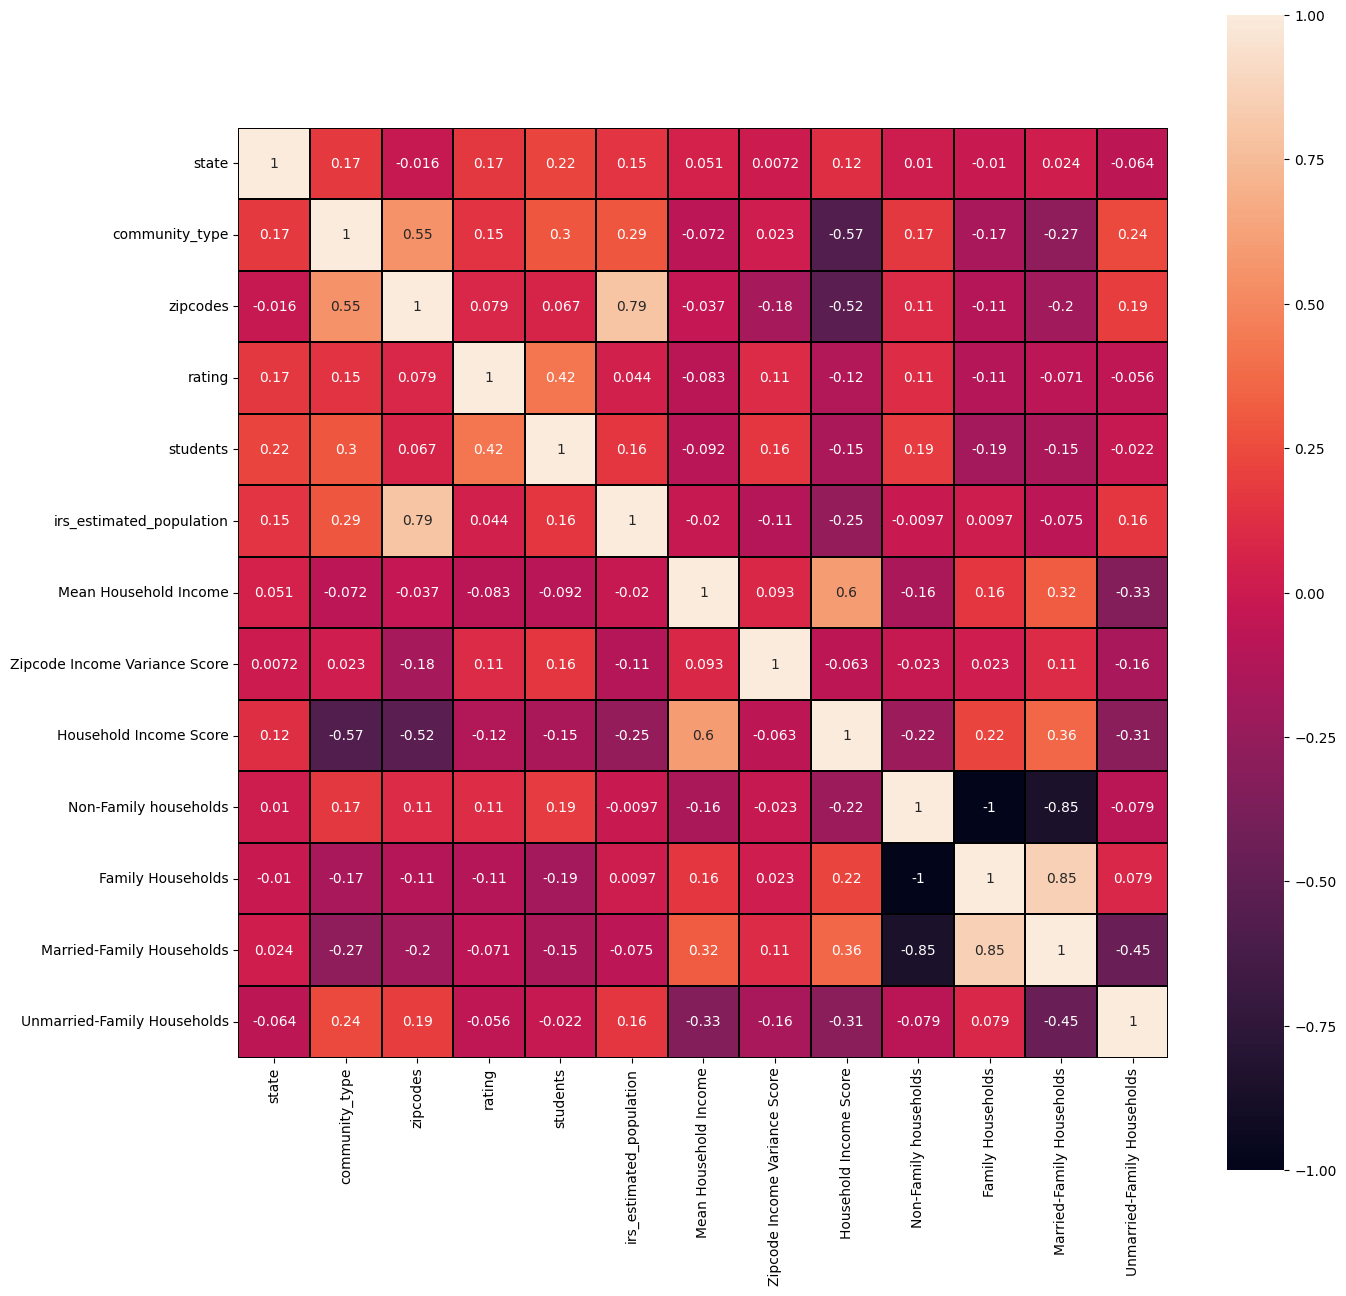

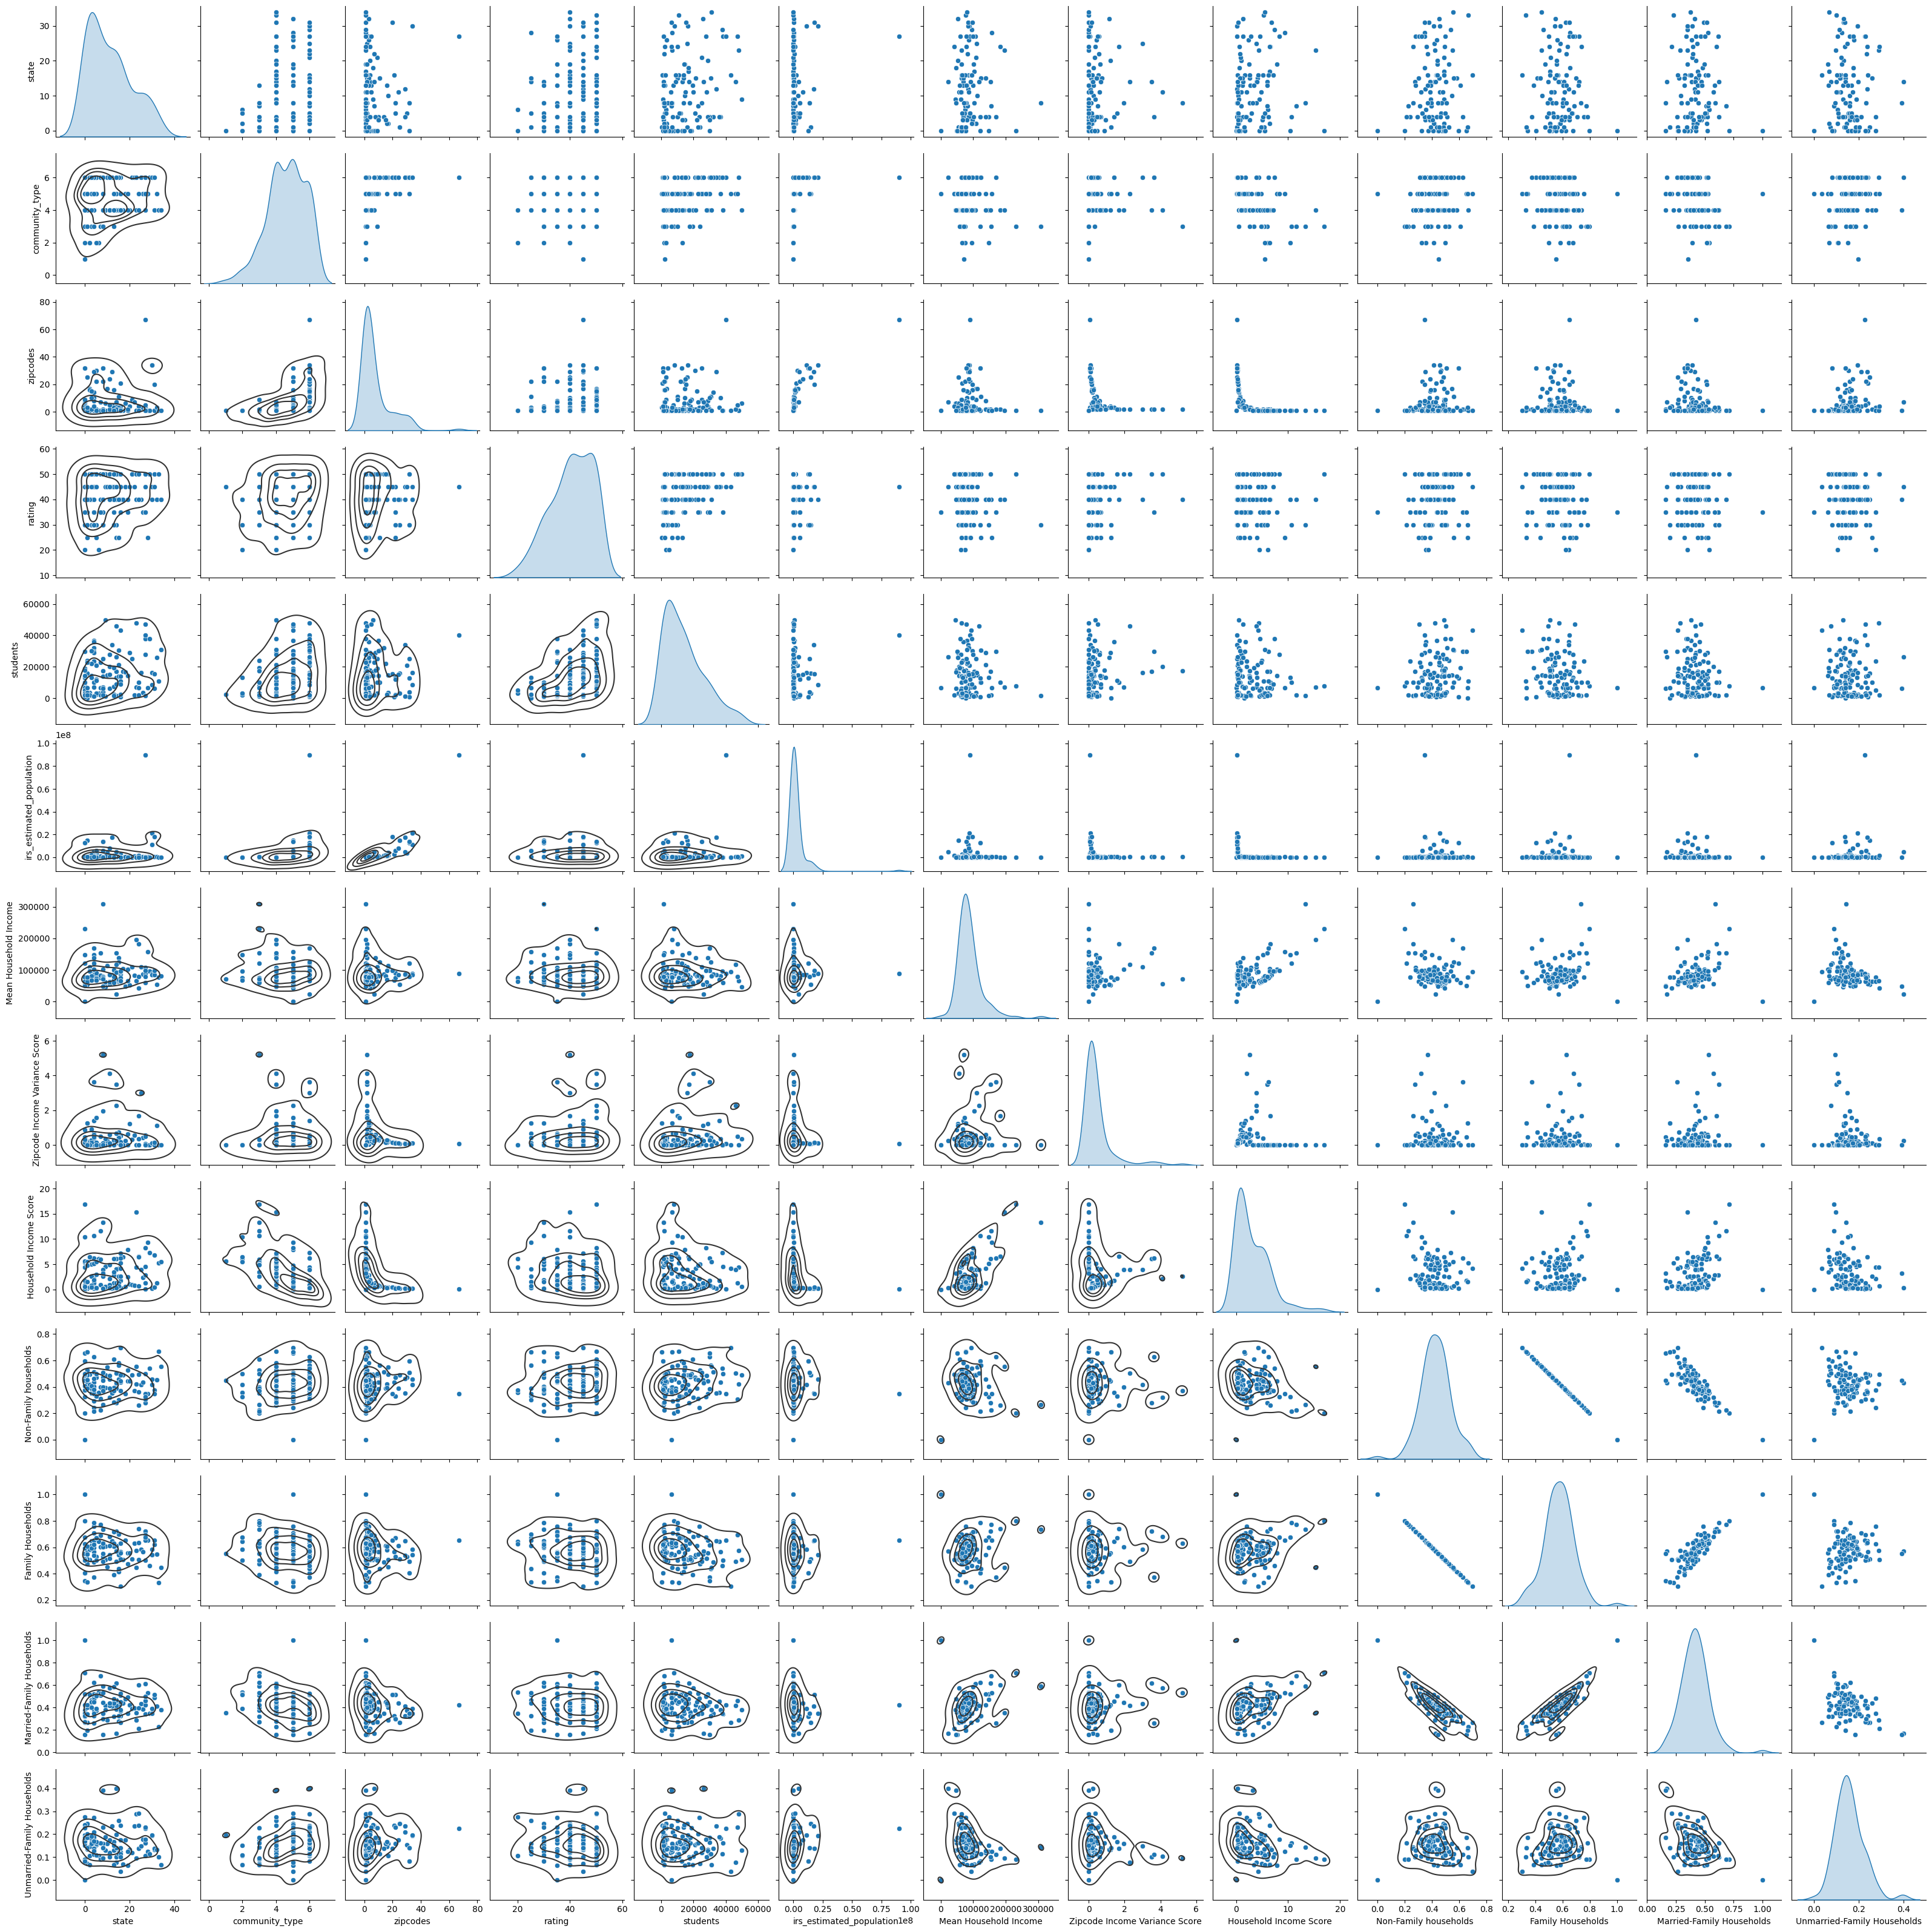

In [96]:
plt.figure(figsize=(15,15))
sns.heatmap(dfn.drop(['campus_name', 'campus_location'], axis=1).corr(), square = True, annot=True, linewidths=.1, linecolor='black')
p = sns.pairplot(dfn.drop(['campus_name', 'campus_location'], axis=1), diag_kind="kde")
p.map_lower(sns.kdeplot, levels=5, color='.2')

# __
There are not really any strong correlations, the ratings being largely evenely distributed on the pairplot is a good indicator that there is little correlation between financial/population statistics and pride rankings. As a final check, I'll add in all the tags in the dataset and verify if there are predictors there.

In [97]:
# as a hail marry, lets bring in all the tags and see what happens
dft = pd.read_csv('rawdata/pride-ranking-dataset/pride_index_tags.csv')
dft = pd.merge(dft, df, on='campus_name', how='inner', indicator=True)
dft.rename(columns={'campus_location_x' : 'campus_location'}, inplace=True)
dft = dft.loc[dft['_merge'] == 'both'].drop('_merge', axis=1)
dft.drop(columns=['campus_location_y', 'hbcu'], inplace=True)
dft['community_type'] = dft['community_type'].apply(convert_comm)
dft['community_type'] = dft['community_type'].astype('int64')
dft['community_type'] = dft['community_type'].astype('category')
dft['state'] = pd.factorize(df['state'])[0]
dft['total_tags'] = dft.select_dtypes(include=['bool']).sum(axis=1)
dft['total_tags'] = dft['total_tags'].astype('int64')

dft

,campus_name,campus_location,public,private,doctoral,masters,baccalaureate,community,residential,nonresidential,...,students,irs_estimated_population,Mean Household Income,Zipcode Income Variance Score,Household Income Score,Non-Family households,Family Households,Married-Family Households,Unmarried-Family Households,total_tags
0,"University of Maryland, College Park","College Park, MD",True,False,True,False,False,False,True,False,...,37952,23770.0,96091.000000,0.000000,7.331500,0.538666,0.461334,0.348554,0.112780,4
1,University of Michigan-Dearborn,"Dearborn, MI",True,False,True,True,True,False,False,True,...,9000,171980.0,91848.500000,0.669600,3.975100,0.390037,0.609963,0.468811,0.141152,5
2,SUNY Westchester Community College,"Valhalla, NY",True,False,False,False,False,True,False,True,...,13000,7900.0,148181.000000,0.000000,10.411200,0.324670,0.675330,0.523647,0.151683,4
3,University at Buffalo,"Buffalo, NY",True,False,True,True,True,False,True,False,...,29850,50728.0,50574.000000,0.471100,1.726250,0.654806,0.345194,0.160562,0.184631,5
4,Emory University,"Atlanta, GA",False,True,True,False,False,False,True,False,...,14769,4010742.0,113042.411765,0.245479,0.429891,0.548440,0.451560,0.291367,0.160192,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Woodbury University,"Burbank, CA",False,True,False,True,True,False,True,False,...,1132,153520.0,101182.750000,0.449717,1.866144,0.381058,0.618942,0.450675,0.168267,7
115,University of Texas Arlington,"Arlington, TX",True,False,True,True,True,False,True,False,...,47000,316395.0,79363.600000,0.494205,1.281264,0.307506,0.692494,0.463116,0.229378,8
116,University of Arkansas at Little Rock,"Little Rock, AR",True,False,True,True,True,False,True,True,...,6712,77626.0,157570.000000,0.000000,9.338000,0.346783,0.653217,0.529791,0.123426,7
117,Bluegrass Community & Technical College (BCTC),"Lexington, KY",False,False,False,False,False,True,False,False,...,14500,612270.0,97642.000000,0.278977,0.738196,0.383537,0.616463,0.453357,0.163105,1


# __
### Warning, ugly plot incoming

<Axes: >

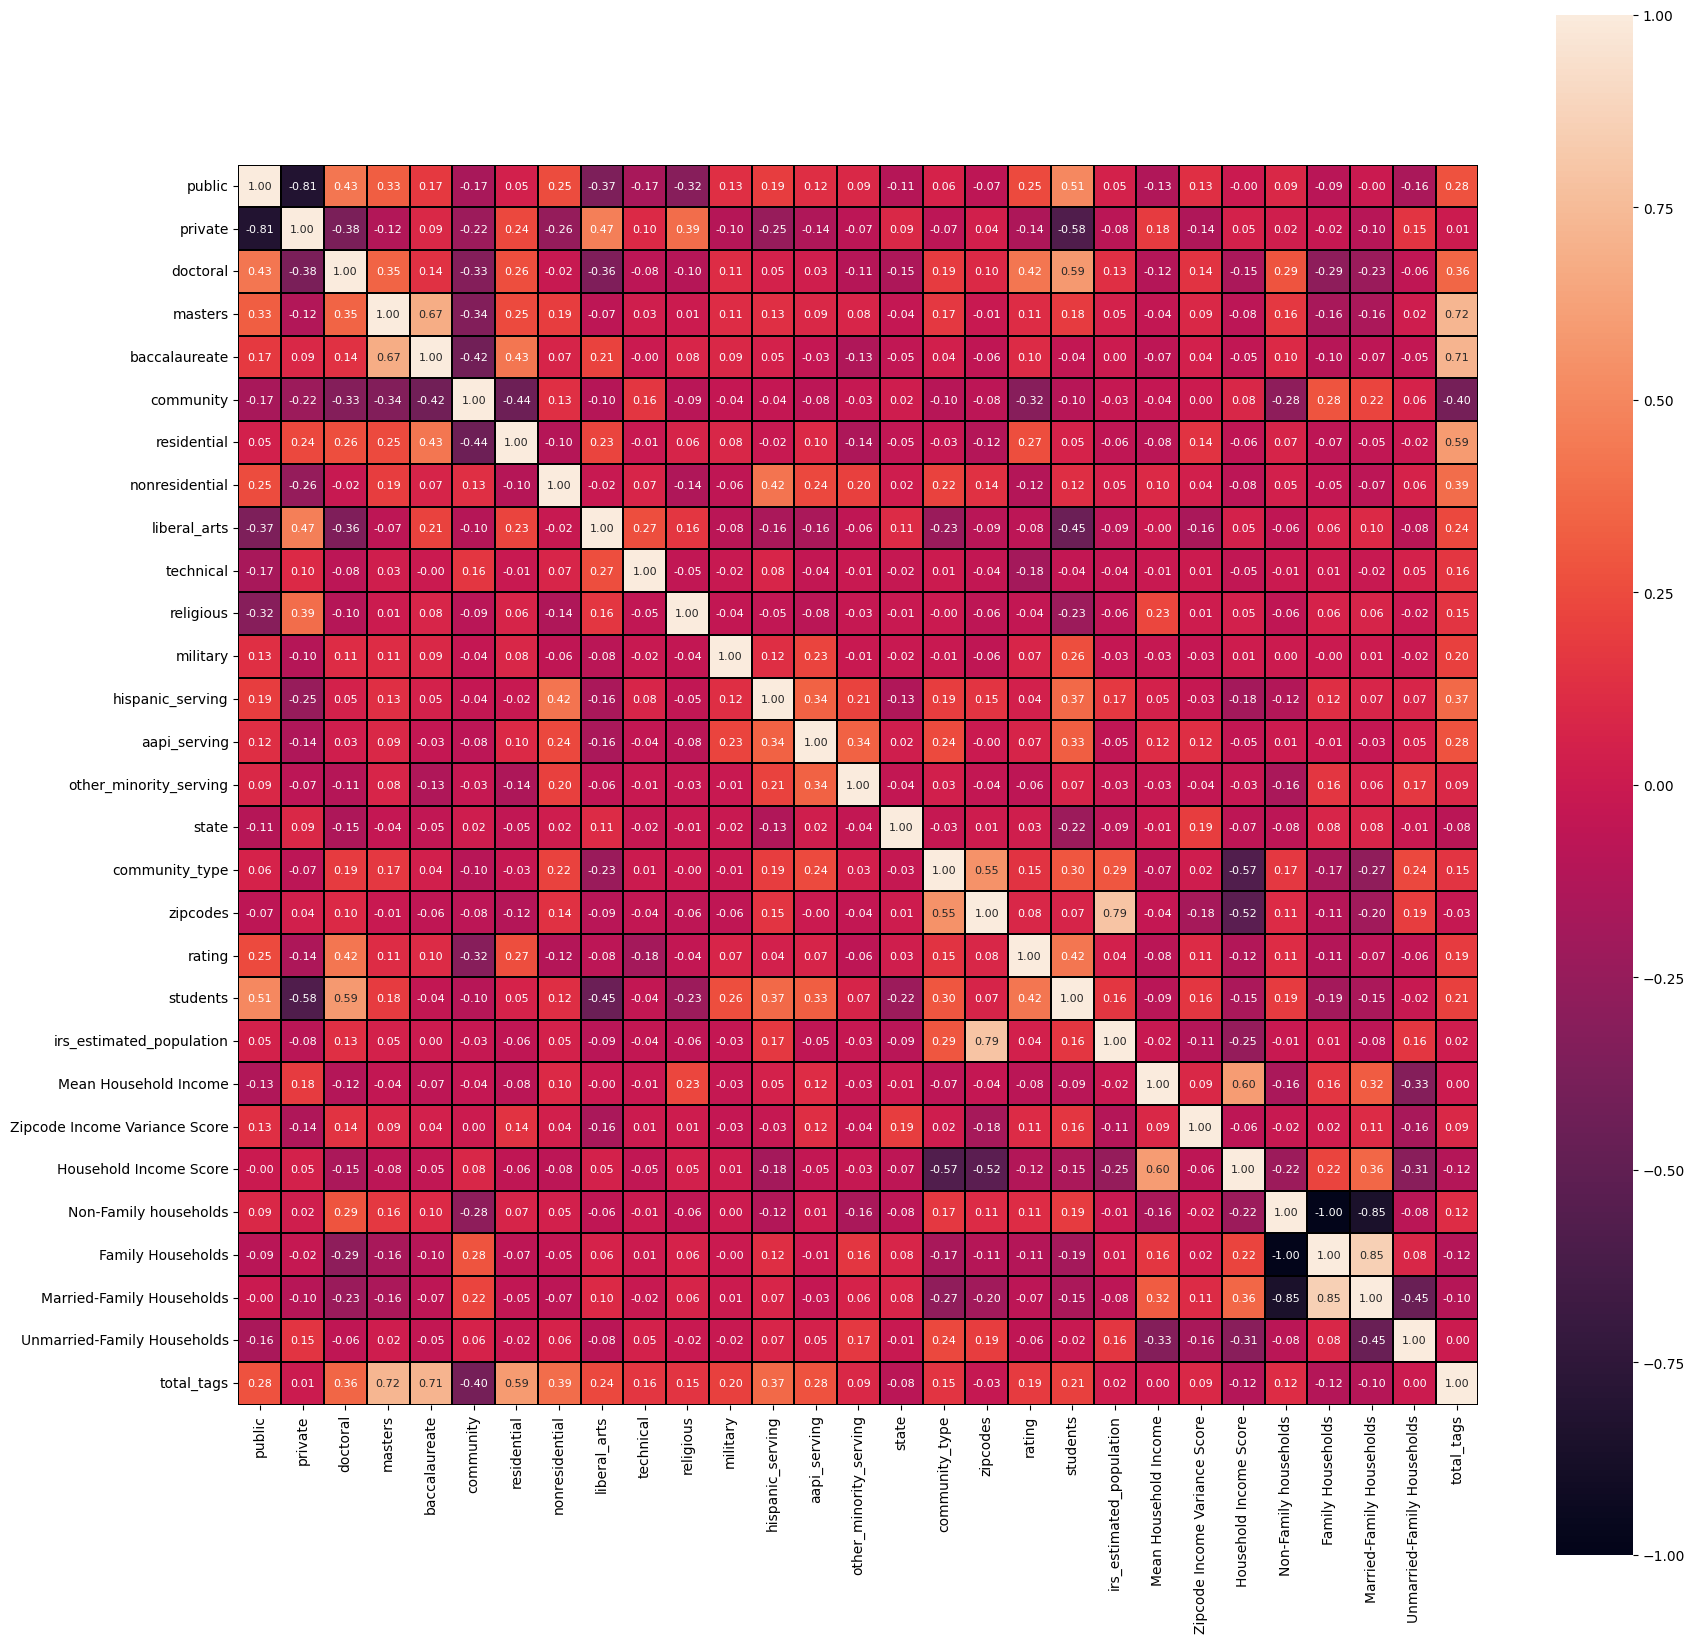

In [98]:
# kitchen sink incomping
plt.figure(figsize=(20, 20))
sns.heatmap(dft.drop(['campus_name', 'campus_location'], axis=1).corr(), square = True, annot=True, linewidths=.1, linecolor='black', annot_kws={'fontsize':8}, fmt=".2f")

# __
There's basically no correlation between ranking and any of the data points. This will be like pulling a rabbit out of a hat fitting a model well to the data, nonetheless I was curious if any unexpected correlations would be found, time to select an algorithim. I'm iffy on whether or not to use the boolean fields. 

In [99]:
dfn.dropna(how='any', inplace=True)

dfn['community_type'] = dfn['community_type'].astype('int64')

dfn.info()
dfn.describe()
dfn

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 0 to 120
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   campus_name                    119 non-null    object  
 1   campus_location                119 non-null    category
 2   state                          119 non-null    int64   
 3   community_type                 119 non-null    int64   
 4   zipcodes                       119 non-null    int64   
 5   rating                         119 non-null    int64   
 6   students                       119 non-null    int64   
 7   irs_estimated_population       119 non-null    float64 
 8   Mean Household Income          119 non-null    float64 
 9   Zipcode Income Variance Score  119 non-null    float64 
 10  Household Income Score         119 non-null    float64 
 11  Non-Family households          119 non-null    float64 
 12  Family Households              119 non-nu

,campus_name,campus_location,state,community_type,zipcodes,rating,students,irs_estimated_population,Mean Household Income,Zipcode Income Variance Score,Household Income Score,Non-Family households,Family Households,Married-Family Households,Unmarried-Family Households
0,Adelphi University,"Garden City, NY",0,3,1,50,7859,4531.0,230942.000000,0.000000,16.932300,0.200688,0.799312,0.709234,0.090078
1,Art Academy of Cincinnati,"Cincinnati, OH",1,5,3,25,260,105243.0,76848.333333,1.249533,1.538656,0.664282,0.335718,0.195527,0.140191
2,Augsburg University,"Minneapolis, MN",2,6,17,50,3537,1622276.0,108819.529412,0.198339,0.479821,0.492180,0.507820,0.401236,0.106584
3,Binghamton University SUNY,"Binghamton, NY",0,4,4,45,18000,74680.0,49595.750000,0.871758,0.888369,0.476588,0.523412,0.361012,0.162401
4,Bluegrass Community & Technical College (BCTC),"Lexington, KY",3,5,10,40,14500,612270.0,97642.000000,0.278977,0.738196,0.383537,0.616463,0.453357,0.163105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Whitman College,"Walla Walla, WA",13,4,1,30,1493,2900.0,78762.000000,0.000000,6.041300,0.370726,0.629274,0.477946,0.151328
117,Wichita State University,"Wichita, KS",11,6,24,40,15000,7988136.0,85387.416667,0.124193,0.286913,0.386725,0.613275,0.439621,0.173654
118,Widener University,"Chester, PA",8,4,1,40,6300,4195.0,47320.000000,0.000000,3.243100,0.447805,0.552195,0.161639,0.390556
119,Woodbury University,"Burbank, CA",4,5,4,30,1132,153520.0,101182.750000,0.449717,1.866144,0.381058,0.618942,0.450675,0.168267


# __
While this isn't the most professional approach, I've decided to work baclwards from the model types and then see why they work. So I selected a model from each of the categories in supervised learning on scikit-learn. 
Those being:
- Linear: RidgeClassifier
- Support Vectors: SVC, Stochastic Gradient: SGDClassifier
- Neighbors: KneighborsClassifier
- Cross Decomp: PLSSVD
- Naive Bayes: GaussianNB
- Decision tree: DecisionTreeClassifier
- Percepitron: MLP Classifier 
- Ensembles: Bagging Classifier

In [237]:
from sklearn import linear_model, svm, neighbors, cross_decomposition, naive_bayes, tree, neural_network,ensemble
from sklearn import model_selection

# Linear: RidgeClassifier
# Support Vectors: SVC
# Stochastic Gradient: SGDClassifier
# Neighbors: KneighborsClassifier
# Naive Bayes: GaussianNB
# Decision tree: DecisionTreeClassifier
# Percepitron: MLP Classifier 
# Ensembles: Bagging Classifier

models = {
    'Linear, RidgeClassifier' : linear_model.RidgeClassifier(),
    'Support Vector, SVC' : svm.SVC(),
    'Stochastic Gradient, SGC' : linear_model.SGDClassifier(),
    'Neighbors, KneighborsClassifier' : neighbors.KNeighborsClassifier(),
    'Naive Bayes, GaussianNB' : naive_bayes.GaussianNB(),
    'Decision Tree, DecisionTreeClassifier' : tree.DecisionTreeClassifier(),
    'Percepitron, MLPClassifier' : neural_network.MLPClassifier(),
    'Ensembles, BaggingClassifier' : ensemble.BaggingClassifier()
}


x_features = dfn.drop(columns=['campus_name', 'campus_location'], axis=1)
y_target = dfn['rating']
best_avg = 0
best_std = -1
best_model = None

# Referenced mwolf for cross_validate
print("Best\t|\tAvg\t|\tStd Dev\t   |\tModel")
print('--------+---------------+------------------+-----------------------------')
for name, model in models.items():
    scores = sklearn.model_selection.cross_validate(model, x_features, y_target, cv=15, scoring = "balanced_accuracy", return_estimator=True, error_score='raise')
    best_index = max(enumerate(scores['test_score']),key=lambda x: x[1])[0] # https://stackoverflow.com/questions/11530799/python-finding-index-of-maximum-in-list
    avg_score = np.mean(scores["test_score"])
    print('{:.5f}'.format(scores['test_score'][best_index]) + '\t|\t{:.5f}'.format(avg_score) + '\t|\t{:.5f}'.format(np.std(scores['test_score'])) + '\t   |\t' + name)
    print('--------+---------------+------------------+-----------------------------')
    if avg_score > best_avg:
        best_model = model
        best_avg = avg_score
        best_std = np.std(scores['test_score'])

print()
print('Best model is ' + str(best_model) + ' with an avg score of {:.4f}'.format(best_avg) + ' and stddev of {:.4f}'.format(best_std) )

Best	|	Avg	|	Std Dev	   |	Model
--------+---------------+------------------+-----------------------------
0.60000	|	0.40222	|	0.13051	   |	Linear, RidgeClassifier
--------+---------------+------------------+-----------------------------
0.30000	|	0.17889	|	0.04732	   |	Support Vector, SVC
--------+---------------+------------------+-----------------------------
0.40000	|	0.16222	|	0.12102	   |	Stochastic Gradient, SGC
--------+---------------+------------------+-----------------------------
0.60000	|	0.22889	|	0.19734	   |	Neighbors, KneighborsClassifier
--------+---------------+------------------+-----------------------------
0.50000	|	0.21667	|	0.16997	   |	Naive Bayes, GaussianNB
--------+---------------+------------------+-----------------------------
1.00000	|	0.97778	|	0.05666	   |	Decision Tree, DecisionTreeClassifier
--------+---------------+------------------+-----------------------------
0.40000	|	0.16667	|	0.11238	   |	Percepitron, MLPClassifier
--------+---------------+----

# __
Well I guess linear algebra is magic, I did not expect that good of predictions. My best guess is that it is so good because of the small sample size so the model is over-fit. This could also explain the huge gap between the effective models and the innefective ones, with most models hovering around 15-20% while the two best are >95% only RidgeClassifier sits between with 37%. I could fuzz and simulate a larger dataset and retest- but this is good enough. The best model flips between BaggingClassifier and DecisionTreeClassifier almost equally.

Prediction accuracy 98: 0.9286
Prediction accuracy 99: 0.6869


Text(0.5, 0.98, 'DecisionTreeClassifier Test\nSizes 98 vs. 99')

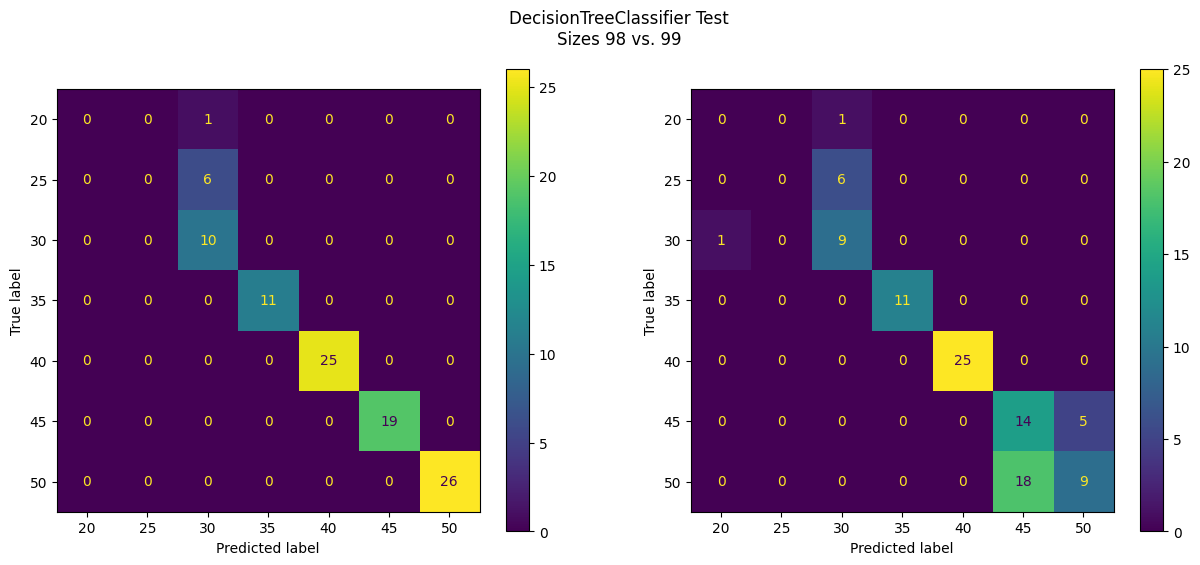

In [252]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

x_feature_train, x_feature_test, y_target_train, y_target_test = train_test_split(x_features, y_target, test_size=98, random_state=237) # different test size changes results like crazy, try 98 vs 99

f = best_model.fit(x_feature_train, y_target_train)
best_pred = f.predict(x_feature_test)
print('Prediction accuracy 98: {:.4f}'.format(accuracy_score(y_target_test, best_pred))) # Michael ref
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ConfusionMatrixDisplay.from_predictions(y_target_test, best_pred, ax=ax1)

x_feature_train, x_feature_test, y_target_train, y_target_test = train_test_split(x_features, y_target, test_size=99 , random_state=237) # different test size changes results like crazy, try 98 vs 99

f = best_model.fit(x_feature_train, y_target_train)
best_pred = f.predict(x_feature_test)
print('Prediction accuracy 99: {:.4f}'.format(accuracy_score(y_target_test, best_pred))) # Michael ref
ConfusionMatrixDisplay.from_predictions(y_target_test, best_pred, ax=ax2)

fig.suptitle('DecisionTreeClassifier Test\nSizes 98 vs. 99')


Prediction accuracy: 0.3426


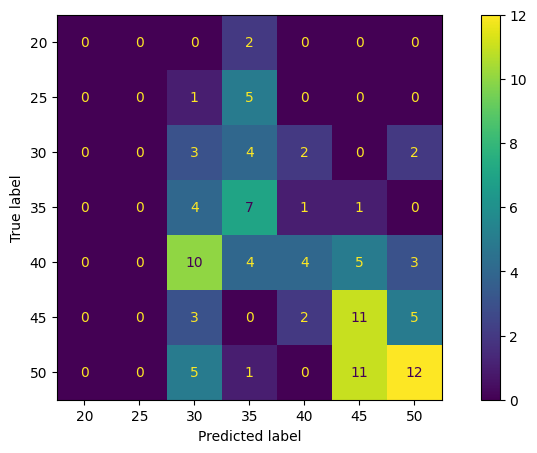

In [232]:
x_feature_train, x_feature_test, y_target_train, y_target_test = train_test_split(x_features, y_target, test_size=0.9 , random_state=237) # different test size changes results like crazy, try 98 vs 99

f = linear_model.RidgeClassifier().fit(x_feature_train, y_target_train)
best_pred = f.predict(x_feature_test)
print('Prediction accuracy: {:.4f}'.format(accuracy_score(y_target_test, best_pred))) # Michael ref
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_target_test, best_pred, ax=ax)
fig.suptitle('RidgeClassifier Test\tSize 0.9')